## Problem Statement
Aim of this project is to implement a Probabilistic Latent Semantic Model. The content of this notebook is three fold:
1. In the first part of the notebook, we will implement pyspark functions able to hande matrix operations. These functions will be useful to implement the algorithm.
2. The second part of the notebook consists in implementing an expectation maximization algorithm and learn its parameters on the MovieLens dataset.
3.  Once we have made sure that the algorithm works correctly, we will see how to use the model in order to recommend some movies to users based on their interests.

## Setup environment

This section contains useful imports and boiler plate to launch your spark session.

In [0]:
!pip install -q mlflow

WARNING: You are using pip version 20.0.2; however, version 21.0.1 is available.
You should consider upgrading via the '/databricks/python3/bin/python3.7 -m pip install --upgrade pip' command.

In [0]:
import os
import time
import zipfile
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mlflow

from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from pyspark.sql import types as st
from pyspark.sql.functions import udf
from pyspark.storagelevel import StorageLevel

In [0]:
%matplotlib inline

In [0]:
# This section configures hdfs root and how to load a spark session.
# Reading can be skipped during the first reading.

def load_spark_session():
  return (
    SparkSession
    .builder
    .appName("Dataset")
    .getOrCreate()
  )

In [0]:
ss = load_spark_session()
ss

Out[5]:

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.0.1 
 Master 
 local[8] 
 AppName 
 Databricks Shell

## Preliminary exercices
In these exercices we will implement matrix operations that will be usefull to run the PLSA algorithm afterwards.

We define a matrix as a column of a spark DataFrame of type array(double), where the arrays of each rows have a fixed size.

#### `matrix_sum_rows` 
Takes a matrix (a column containing arrays of fixed length) and returns the sum of each row.

In [0]:
# Hint: https://stackoverflow.com/a/57448698/2015762
def matrix_sum_rows(col_name, length_of_array):
    #return sf.col(col_name)
    return  sum([sf.col(col_name).getItem(i) for i in range(length_of_array)])

input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    ss.sparkContext.parallelize(input_array.tolist()).map(lambda x: st.Row(matrix=x)).toDF()
    .withColumn('row_sum', matrix_sum_rows('matrix', 4))
).show(truncate=False)

Input array
[[ 1. 2. 3. 4.]
 [40. 30. 20. 10.]]
Expected output
[ 10. 100.]
Obtained output
+------------------------+-------+
matrix |row_sum|
+------------------------+-------+
[1.0, 2.0, 3.0, 4.0] |10.0 |
[40.0, 30.0, 20.0, 10.0]|100.0 |
+------------------------+-------+

#### `matrix_sum_columns`
Takes a matrix (a column containing arrays of fixed length) and returns the sum of each column.

In [0]:
# Hint: https://stackoverflow.com/a/54382990/2015762
def matrix_sum_columns(col_name, length_of_array):
    #return sf.sum(sf.col(col_name)[0])
    return  sf.array([sf.sum(sf.col(col_name)[i]) for i in range(length_of_array)])

input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=0)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    ss.sparkContext.parallelize(input_array.tolist()).map(lambda x: st.Row(matrix=x)).toDF()
    .select(matrix_sum_columns('matrix', 4).alias('col_sum'))
).show(truncate=False)

Input array
[[ 1. 2. 3. 4.]
 [40. 30. 20. 10.]]
Expected output
[41. 32. 23. 14.]
Obtained output
+------------------------+
col_sum |
+------------------------+
[41.0, 32.0, 23.0, 14.0]|
+------------------------+

#### `matrix_normalize_rows`
Takes a matrix (a column containing arrays of fixed length) and returns the same matrix where the rows have been divded by their sum, such that each row sums to 1.

In [0]:
def matrix_normalize_rows(col_name, length_of_array):
    row_sum = matrix_sum_rows(col_name, length_of_array)
    return sf.array([sf.col(col_name).getItem(i)/row_sum for i in range(length_of_array)])

input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array / input_array.sum(axis=1).reshape(-1, 1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    ss.sparkContext.parallelize(input_array.tolist()).map(lambda x: st.Row(numbers=x)).toDF()
    .withColumn('normalized_elements', matrix_normalize_rows('numbers', 4))
).show(truncate=False)

Input array
[[ 1. 2. 3. 4.]
 [40. 30. 20. 10.]]
Expected output
[[0.1 0.2 0.3 0.4]
 [0.4 0.3 0.2 0.1]]
Obtained output
+------------------------+--------------------+
numbers |normalized_elements |
+------------------------+--------------------+
[1.0, 2.0, 3.0, 4.0] |[0.1, 0.2, 0.3, 0.4]|
[40.0, 30.0, 20.0, 10.0]|[0.4, 0.3, 0.2, 0.1]|
+------------------------+--------------------+

#### `matrix_elementwise_product`
Takes two matrices and return their elementwise product (aka. Hadamard product)

In [0]:
def matrix_elementwise_product(col_name_1, col_name_2, length_of_array):
    return sf.array([sf.col(col_name_1).getItem(i)*sf.col(col_name_2).getItem(i) for i in range(length_of_array)])

input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 * input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    ss.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(lambda x: st.Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .withColumn('elementwise_products', matrix_elementwise_product('numbers_1', 'numbers_2', 4))
).show(truncate=False)

Input array
[[ 1. 2. 3. 4.]
 [40. 30. 20. 10.]]
[[ 1. 2. 1. 2.]
 [10. 20. 10. 20.]]
Expected output
[[ 1. 4. 3. 8.]
 [400. 600. 200. 200.]]
Obtained output
+------------------------+------------------------+----------------------------+
numbers_1 |numbers_2 |elementwise_products |
+------------------------+------------------------+----------------------------+
[1.0, 2.0, 3.0, 4.0] |[1.0, 2.0, 1.0, 2.0] |[1.0, 4.0, 3.0, 8.0] |
[40.0, 30.0, 20.0, 10.0]|[10.0, 20.0, 10.0, 20.0]|[400.0, 600.0, 200.0, 200.0]|
+------------------------+------------------------+----------------------------+

#### `matrix_elementwise_divide`
Takes two matrices and divide elementwise the first one by the second one.

In [0]:
def matrix_elementwise_divide(col_name_1, col_name_2, length_of_array):
    return sf.array([sf.col(col_name_1).getItem(i)/sf.col(col_name_2).getItem(i) for i in range(length_of_array)])

input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 / input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    ss.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(lambda x: st.Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .withColumn('elementwise_divided', matrix_elementwise_divide('numbers_1', 'numbers_2', 4))
).show(truncate=False)

Input array
[[ 1. 2. 3. 4.]
 [40. 30. 20. 10.]]
[[ 1. 2. 1. 2.]
 [10. 20. 10. 20.]]
Expected output
[[1. 1. 3. 2. ]
 [4. 1.5 2. 0.5]]
Obtained output
+------------------------+------------------------+--------------------+
numbers_1 |numbers_2 |elementwise_divided |
+------------------------+------------------------+--------------------+
[1.0, 2.0, 3.0, 4.0] |[1.0, 2.0, 1.0, 2.0] |[1.0, 1.0, 3.0, 2.0]|
[40.0, 30.0, 20.0, 10.0]|[10.0, 20.0, 10.0, 20.0]|[4.0, 1.5, 2.0, 0.5]|
+------------------------+------------------------+--------------------+

## Load Movie Lens dataset

In [0]:
# Remove from cache all data from preliminary exercices
ss.catalog.clearCache()

In [0]:
# This section defines utility method to load our dataset.
# Reading can be skipped during the first reading.
def download_dataset(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)
    urllib.request.urlretrieve(
        "http://files.grouplens.org/datasets/movielens/ml-20m.zip", 
        "movie_lens_data/ml-20m.zip"
    )
    with zipfile.ZipFile("movie_lens_data/ml-20m.zip", "r") as zip_ref:
        zip_ref.extractall(dataset_path)

In [0]:
download_dataset(os.path.abspath('movie_lens_data'))

In [0]:
hdfs_prefix = 'file:///databricks/driver/'
movies_path = f"{hdfs_prefix}/movie_lens_data/ml-20m/movies.csv"
ratings_path= f"{hdfs_prefix}/movie_lens_data/ml-20m/ratings.csv"

In [0]:
movies_df = ss.read.options(header=True).csv(movies_path)
ratings_df = ss.read.options(header=True).csv(ratings_path)
positive_ratings_df = ratings_df.filter("rating>=3.5").cache()

In [0]:
movies_df.show(3)
ratings_df.show(3)

+-------+--------------------+--------------------+
movieId| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|Adventure|Animati...|
 2| Jumanji (1995)|Adventure|Childre...|
 3|Grumpier Old Men ...| Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows

+------+-------+------+----------+
userId|movieId|rating| timestamp|
+------+-------+------+----------+
 1| 2| 3.5|1112486027|
 1| 29| 3.5|1112484676|
 1| 32| 3.5|1112484819|
+------+-------+------+----------+
only showing top 3 rows

## Probabilistic Latent Semantic Analysis (PLSA)

### Preprocess dataset

In [0]:
# Control the dataset size to work with a small dataset.
# You can decrease these parameters for a deeper analysis.

# Select only the movies with a certain amount of positive ratings
min_positive_ratings_per_movie = 10000
selected_movies_df = (
    positive_ratings_df
    .groupBy('movieId')
    .count()
    .filter(sf.col('count') > min_positive_ratings_per_movie)
    .select('movieId')
)

# keep only 1 out of x user
keep_user_every = 100
user_movies_interactions = (
    positive_ratings_df
    .join(selected_movies_df, on='movieId')
    .filter(sf.expr(f'PMOD(HASH(userId),{keep_user_every})')==0)
    .select('userId', 'movieId')
    .repartition('userId', 'movieId')
).cache()

### Question
What is the meaning of `.filter(sf.expr(f'PMOD(HASH(userId),{keep_user_every})')==0)` ? Why did we not use `.sample()` instead?

The filter is applied on the dataframe shown above and keeps the comments of only 1 out of X users. (Thus not necessarily strictly 1/X % of the dataset if some users made several comments) 
The function PMOD is the modulo operation and the function HASH allows for a generic code, which would work for a string input (eg: sampling on producer name or movie genre instead). Here it can be replaced by INT. 
The advantage of using this filter instead of the sample function is that the process is not randomized.

In [0]:
# Analysis: count the size of the subsample in terms of nb_ratings/total_nb_ratings
# min_size = (nb_users/X)/total_nb_ratings
# max_size = (?)/total_nb_ratings

In [0]:
user_movies_interactions.select(
    sf.count('*').alias('n_pairs'),
    sf.countDistinct('userId').alias('n_users'),
    sf.countDistinct('movieId').alias('n_movies'),
).show()

+-------+-------+--------+
n_pairs|n_users|n_movies|
+-------+-------+--------+
 43682| 1341| 247|
+-------+-------+--------+

### PLSA Implementation

Ressources
* Original paper : https://arxiv.org/pdf/1301.6705.pdf
* Clear rephrasing : https://link.springer.com/article/10.1023/A:1007617005950 (Section 3)
* Map reduce implementation by Google News : https://www2007.org/papers/paper570.pdf (We will use their notations from page 275).

Try to recommend movies to users given:
* N the number of users u
* M the number of movies s
* L the number of latent classes z
* T number of user, movie interactions (each interaction (s_t, u_t) means user u_t liked movie s_t)

We suppose that the probability that a user will like a movie can be written in the form of a mixture model given by the equation:
$$
p(s|u) = \sum_{z=1}^L p(s|z) p(z|u)
$$
And we want to maximize the log-likelihood of the observed user interactions
$$
L = - \frac{1}{T} \sum_{t=1}^{T} \log p(s_t|u_t) = - \frac{1}{T} \sum_{1}^{T} \sum_{z=1}^L p(s_t|z) p(z|u_t)
$$
That can be done using an EM algorithm working as follow:

**E step**

For each interaction (u_t, s_t), compute for all z = 1, ..., L:
$$
p(z|(u_t, s_t)) = \frac{p(s_t|z) p(z|u_t)}{\sum_z p(s_t|z) p(z|u_t)}
$$

**M step**

Find each movie probability given a latent class
$$
p(s|z) = \frac{N(z, s)}{N(z)} 
\quad \text{where} \quad N(z, s) = \sum_u p(z|(u, s)) 
\quad \text{and} \quad N(z) = \sum_s N(z, s)
$$
Find each latent class probability given each user.
$$
p(z|u) = \frac{\sum_s p(z|(u, s))}{\sum_z \sum_s p(z|(u, s))}
$$

We will have the following dataframes in which the latent variables z are stored in columns of array\<double\>. Latent variable z_i is stored at index i of this array.

* `count_z_s`: M rows, with 2 columns  `movieId` (int), `N(z,s)` (array\<double\>).
* `count_z`: 1 row, with 1 column `N(z)`.
* `p_s_knowing_z`: M rows, with 2 columns  `movieId` (int), `p(s|z)` (array\<double\>). For a given z, the sum of p(s|z) equals 1.
* `p_z_knowing_u`: N rows, with 2 columns `userId` (int), `p(z|u)` (array\<double\>). For a given u, the sum of p(z|u) equals 1.
* `p_z_knowing_u_and_s`: N x M rows, with 3 columns `userId` (int), `movieId` (int), `p(z|u,s)` (array\<double\>).

We will now implement methods that compute each of these equations.

In [0]:
def get_count_z(count_z_s, n_latent_classes):
    """Compute N(z) = sum_s N(z,s)
    returns a DF with column movieId and N(z,s)
    """
    return count_z_s.select(matrix_sum_columns("N(z,s)", n_latent_classes).alias("N(z)"))

# TEST FOR get_count_z

count_z_s = ss.sparkContext.parallelize([
    st.Row(**{"movieId":1, "N(z,s)": [0.4, 1.1, 0.5]}),
    st.Row(**{"movieId":2, "N(z,s)": [0.4, 1.4, 0.3]}),
]).toDF()
get_count_z(count_z_s, 3).show()
"""
Expected:
count_z_s = ss.sparkContext.parallelize([
    st.Row(**{"N(z,s)": [0.8, 2.5, 0.8]}),
]).toDF()
"""

+---------------+
 N(z)|
+---------------+
[0.8, 2.5, 0.8]|
+---------------+

Out[17]: '\nExpected:\ncount_z_s = ss.sparkContext.parallelize([\n st.Row(**{"N(z,s)": [0.8, 2.5, 0.8]}),\n]).toDF()\n'

In [0]:
def get_count_z_s(p_z_knowing_u_and_s, n_latent_classes):
    """Compute N(z,s) = sum_u p(z|u,s)
    array de taille nb classe latentes
    """
    count_z_s = p_z_knowing_u_and_s.groupby("movieId").agg(matrix_sum_columns("p(z|u,s)", n_latent_classes).alias("N(z,s)"))
    return count_z_s.select("movieId", sf.array([sf.col("N(z,s)").getItem(i) for i in range(n_latent_classes)]).alias("N(z,s)"))
  
# TEST FOR get_count_z_s

p_z_knowing_u_and_s = ss.sparkContext.parallelize([
    st.Row(**{"userId":1, "movieId":1, "p(z|u,s)": [.1, .3, .4]}),
    st.Row(**{"userId":1, "movieId":2, "p(z|u,s)": [.4, .5, .0]}),
    st.Row(**{"userId":2, "movieId":1, "p(z|u,s)": [.3, .8, .1]}),
    st.Row(**{"userId":2, "movieId":2, "p(z|u,s)": [.0, .9, .3]}),
]).toDF()
get_count_z_s(p_z_knowing_u_and_s, 3).show()
"""
Expected:
count_z_s = ss.sparkContext.parallelize([
    st.Row(**{"movieId":1, "N(z,s)": [0.4, 1.1, 0.5]}),
    st.Row(**{"movieId":2, "N(z,s)": [0.4, 1.4, 0.3]}),
]).toDF()
"""

+-------+---------------+
movieId| N(z,s)|
+-------+---------------+
 1|[0.4, 1.1, 0.5]|
 2|[0.4, 1.4, 0.3]|
+-------+---------------+

Out[18]: '\nExpected:\ncount_z_s = ss.sparkContext.parallelize([\n st.Row(**{"movieId":1, "N(z,s)": [0.4, 1.1, 0.5]}),\n st.Row(**{"movieId":2, "N(z,s)": [0.4, 1.4, 0.3]}),\n]).toDF()\n'

In [0]:
def get_p_s_knowing_z(count_z_s, count_z, n_latent_classes):
    """Compute p(s|z) = N(z,s) / N(z)
    
    Hint: crossJoin may help
    """
    join = count_z_s.crossJoin(count_z) # Cartesian product
    # join = count_z_s.join(count_z, count_z_s.movieId == count_z.movieId)
    return join.select("movieId", matrix_elementwise_divide('N(z,s)', 'N(z)', n_latent_classes).alias("p(s|z)"))
  
# TEST FOR get_p_s_knowing_z

count_z_s = ss.sparkContext.parallelize([
    st.Row(**{"movieId":1, "N(z,s)": [0.4, 1.1, 0.5]}),
    st.Row(**{"movieId":2, "N(z,s)": [0.4, 1.4, 0.3]}),
]).toDF()

count_z = get_count_z(count_z_s, 3)
"""
Expected:
count_z_s = ss.sparkContext.parallelize([
    st.Row(**{"N(z,s)": [0.8, 2.5, 0.8]}),
]).toDF()
"""

get_p_s_knowing_z(count_z_s, count_z, 3).show(truncate=False)
"""
Expected:
p_s_knowing_z = ss.sparkContext.parallelize([
    st.Row(**{"movieId":1, "p(s|z)": [0.5, 0.44, 0.625]}),
    st.Row(**{"movieId":2, "p(s|z)": [0.5, 0.56, 0.375]}),
]).toDF()

Note that the sum over the columns equals 1
"""

+-------+----------------------------------------------+
movieId|p(s|z) |
+-------+----------------------------------------------+
1 |[0.5, 0.44000000000000006, 0.625] |
2 |[0.5, 0.5599999999999999, 0.37499999999999994]|
+-------+----------------------------------------------+

Out[25]: '\nExpected:\np_s_knowing_z = ss.sparkContext.parallelize([\n st.Row(**{"movieId":1, "p(s|z)": [0.5, 0.44, 0.625]}),\n st.Row(**{"movieId":2, "p(s|z)": [0.5, 0.56, 0.375]}),\n]).toDF()\n\nNote that the sum over the columns equals 1\n'

In [0]:
def get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes):
    """Compute p(z|u) = sum_s p(z|u,s) / sum_z sum_s p(z|u,s)
    """
    # sum rows by common userId and normalize
    count_z_u = p_z_knowing_u_and_s.groupby("userId").agg(matrix_sum_columns("p(z|u,s)", n_latent_classes).alias("N(z,u)"))
    return count_z_u.select("userId", matrix_normalize_rows("N(z,u)", n_latent_classes).alias("p(z|u)"))
  
# TEST FOR get_p_z_knowing_u

# p_z_knowing_u_and_s = ss.sparkContext.parallelize([
#     st.Row(**{"userId":1, "movieId":1, "p(z|u,s)": [.1, .3, .4]}),
#     st.Row(**{"userId":1, "movieId":2, "p(z|u,s)": [.4, .5, .0]}),
#     st.Row(**{"userId":2, "movieId":1, "p(z|u,s)": [.3, .8, .1]}),
#     st.Row(**{"userId":2, "movieId":2, "p(z|u,s)": [.0, .9, .3]}),
# ]).toDF()
p_z_knowing_u_and_s = ss.sparkContext.parallelize([
    st.Row(**{"userId":"1", "movieId":"1", "p(z|u,s)": [.1, .3, .4]}),
    st.Row(**{"userId":"1", "movieId":"2", "p(z|u,s)": [.4, .5, .0]}),
    st.Row(**{"userId":"2", "movieId":"1", "p(z|u,s)": [.3, .8, .1]}),
    st.Row(**{"userId":"2", "movieId":"2", "p(z|u,s)": [.0, .9, .3]}),
]).toDF()

get_p_z_knowing_u(p_z_knowing_u_and_s, 3).show(truncate=False)
"""
Expected: sum rows by common userId and normalize
[0.5, 0.8, 0.4]/1.7, [0.3, 1.7, 0.4]/2.4
p_z_knowing_u = ss.sparkContext.parallelize([
    st.Row(**{"userId":1, "p(z|u)": [0.294, 0.471, 0.235]}),
    st.Row(**{"userId":2, "p(z|u)": [0.125, 0.708, 0.167]}),
]).toDF()

Note that the sum over the rows equals 1
"""

+------+--------------------------------------------------------------+
userId|p(z|u) |
+------+--------------------------------------------------------------+
1 |[0.2941176470588235, 0.47058823529411764, 0.23529411764705882]|
2 |[0.125, 0.7083333333333335, 0.16666666666666669] |
+------+--------------------------------------------------------------+

Out[26]: '\nExpected: sum rows by common userId and normalize\n[0.5, 0.8, 0.4]/1.7, [0.3, 1.7, 0.4]/2.4\np_z_knowing_u = ss.sparkContext.parallelize([\n st.Row(**{"userId":1, "p(z|u)": [0.294, 0.471, 0.235]}),\n st.Row(**{"userId":2, "p(z|u)": [0.125, 0.708, 0.167]}),\n]).toDF()\n\nNote that the sum over the rows equals 1\n'

In [0]:
user_movies_interactions.show(10)

+------+-------+
userId|movieId|
+------+-------+
 17506| 296|
127487| 296|
 11078| 1394|
104427| 1394|
 28260| 58559|
121358| 58559|
104427| 1265|
123603| 3949|
 27248| 919|
 27317| 919|
+------+-------+
only showing top 10 rows

In [0]:
def get_p_z_knowing_u_and_s(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes):
    """For all pairs of observed (u, s)
    
    Compute p(z|u,s) = [N(z, s) / N(z) * p(z|u)] / sum_z [N(z, s) / N(z) * p(z|u)]
                     = [p(s|z) * p(z|u)] / sum_z [p(s|z) * p(z|u)] #Normalize ?
    """
    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)
    
    joined_data = observed_pairs.join(p_s_knowing_z, on='movieId').join(p_z_knowing_u, on='userId')
    
    product = joined_data.select("userID", "movieId", matrix_elementwise_product('p(s|z)', 'p(z|u)', n_latent_classes).alias("product"))

    return product.select("userID", "movieId", matrix_normalize_rows("product", n_latent_classes).alias("p(z|u,s)"))
  
# TEST FOR get_p_z_knowing_u_and_s

# observed_pairs = user_movies_interactions
observed_pairs = ss.sparkContext.parallelize([
    st.Row(**{"userId":1, "movieId":1}),
    st.Row(**{"userId":1, "movieId":2}),
    st.Row(**{"userId":2, "movieId":1}),
    st.Row(**{"userId":2, "movieId":2}),
]).toDF()

count_z_s = ss.sparkContext.parallelize([
    st.Row(**{"movieId":1, "N(z,s)": [0.4, 1.1, 0.5]}),
    st.Row(**{"movieId":2, "N(z,s)": [0.4, 1.4, 0.3]}),
]).toDF()

count_z = get_count_z(count_z_s, 3)

p_z_knowing_u = ss.sparkContext.parallelize([
    st.Row(**{"userId":1, "p(z|u)": [0.294, 0.471, 0.235]}),
    st.Row(**{"userId":2, "p(z|u)": [0.125, 0.708, 0.167]}),
]).toDF()

get_p_z_knowing_u_and_s(observed_pairs, count_z_s, count_z, p_z_knowing_u, 3).show()

+------+-------+--------------------+
userID|movieId| p(z|u,s)|
+------+-------+--------------------+
 1| 2|[0.29465708530021...|
 1| 1|[0.29334583877952...|
 2| 2|[0.11982247102692...|
 2| 1|[0.13064517814776...|
+------+-------+--------------------+

In [0]:
def log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes):
    """Compute the log likelihood of the observed pairs
    
    L = - 1 / T * sum_t log[ p(s|u) ]
      = - 1 / T * sum_t log[ sum_z p(s|z) * p(z|u) ]
    """
                   
    T = observed_pairs.count()
                   
    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)
    
    joined_data = observed_pairs.join(p_s_knowing_z, on='movieId').join(p_z_knowing_u, on='userId')
    
    product = joined_data.select("userId", "movieId", matrix_elementwise_product('p(s|z)', 'p(z|u)', n_latent_classes).alias("product"))
    
    p_s_knowing_u = product.select("userId", "movieId", matrix_sum_rows('product', n_latent_classes).alias("p(s|u)"))
    
    log_values = p_s_knowing_u.select("userId", "movieId", sf.log("p(s|u)").alias("log(p(s|u))"))
    
    sum_logs = log_values.select(sf.sum(sf.col('log(p(s|u))')).alias('sum_logs')).collect()[0][0]
    return -sum_logs/T
                   
# TEST FOR log_likelihood

# observed_pairs = user_movies_interactions
observed_pairs = ss.sparkContext.parallelize([
    st.Row(**{"userId":1, "movieId":1}),
    st.Row(**{"userId":1, "movieId":2}),
    st.Row(**{"userId":2, "movieId":1}),
    st.Row(**{"userId":2, "movieId":2}),
]).toDF()
                   
log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, 3)

Out[32]: 0.6936156361159181

### Initialization
If we were to set all the probability to the same value, it would be the same as showing users have no preference for any latent class of movies. Thus the algorithm would be at a standstill.

In [0]:
n_latent_classes = 3

def initialize_statistics(observed_pairs, n_latent_classes):
    """Initialize either p(s|z) and p(z|u) or p(z|(u, s)) to be able to fuel the first iteration of the EM algorithm.
    What would happen if you initialize these to a constant value ?
    """
    # Initialize at random
    return observed_pairs.withColumn("p(z|u,s)", sf.array([sf.rand() for i in range(n_latent_classes)]))
  
# TEST FOR initialize_statistics

# observed_pairs = user_movies_interactions
observed_pairs = ss.sparkContext.parallelize([
    st.Row(**{"userId":1, "movieId":1}),
    st.Row(**{"userId":1, "movieId":2}),
    st.Row(**{"userId":2, "movieId":1}),
    st.Row(**{"userId":2, "movieId":2}),
]).toDF()
                   
initialize_statistics(observed_pairs, n_latent_classes).show(truncate=False)

+------+-------+--------------------------------------------------------------+
userId|movieId|p(z|u,s) |
+------+-------+--------------------------------------------------------------+
1 |1 |[0.14745169119994328, 0.7705423410391268, 0.19937207638070098]|
1 |2 |[0.2859202548600991, 0.8072407637202066, 0.4701923876403372] |
2 |1 |[0.33557029789487836, 0.6972533413106486, 0.4185699880687138] |
2 |2 |[0.14213142225011077, 0.8767312523536608, 0.10355664965591593]|
+------+-------+--------------------------------------------------------------+

In [0]:
def run_plsi(observed_pairs, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    ss.sparkContext.setJobDescription("Initialization")

    p_z_knowing_u_and_s = initialize_statistics(observed_pairs, n_latent_classes).localCheckpoint()#.cache()
    p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()#.cache()
    count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()#.cache()
    count_z = get_count_z(count_z_s, n_latent_classes).localCheckpoint()#.cache()
    p_z_knowing_u_and_s.unpersist()
    llh = log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
    mlflow.log_metric(key="llh", value=llh, step=0)
    print(f'LLH: {llh:.10f}')
    
    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')
    
    iter_computation_times = [end_init_time - start_init_time]
    for i in range(n_iterations):
        start_e_step = time.time()
        ss.sparkContext.setJobDescription(f"Iteration {i+1}: E-step")
        # E step
        p_z_knowing_u_and_s = get_p_z_knowing_u_and_s(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes).localCheckpoint()
        p_z_knowing_u.unpersist()
        count_z_s.unpersist()
        count_z.unpersist()
        
        
        end_e_step = time.time()
#         print(f'Iteration {i+1}: E-step: {end_e_step - start_e_step:.1f}s')
        
        ss.sparkContext.setJobDescription(f"Iteration {i+1}: M-step")
        # M step
        p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()#.cache()
        count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()#.cache()
        count_z = get_count_z(count_z_s, n_latent_classes).localCheckpoint()#.cache()
        p_z_knowing_u_and_s.unpersist()
        
        llh = log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
        mlflow.log_metric(key="llh", value=llh, step=i+1)
        
        end_m_step = time.time()
#         print(f'Iteration {i+1}: M-step: {end_m_step - end_e_step:.1f}s')
        print(f'LLH: {llh:.10f}')
        
        step_time = end_m_step - start_e_step
        iter_computation_times.append(step_time)
        print(f'Iteration {i+1}: Total: {step_time:.1f}s')
            
    return get_p_s_knowing_z(count_z_s, count_z, n_latent_classes), iter_computation_times

### Running the algorithm

In [0]:
n_iterations = 40
n_latent_classes = 2

with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    p_s_knowing_z, iter_computation_times = run_plsi(user_movies_interactions, n_iterations=n_iterations, n_latent_classes=n_latent_classes)

LLH: 5.4079461563
Initialization: 18.1s
LLH: 5.4074729502
Iteration 1: Total: 9.2s
LLH: 5.4074154630
Iteration 2: Total: 10.0s
LLH: 5.4073376443
Iteration 3: Total: 10.3s
LLH: 5.4072195681
Iteration 4: Total: 9.8s
LLH: 5.4070236544
Iteration 5: Total: 10.4s
LLH: 5.4066738283
Iteration 6: Total: 10.1s
LLH: 5.4060111266
Iteration 7: Total: 10.7s
LLH: 5.4047015056
Iteration 8: Total: 10.6s
LLH: 5.4020598643
Iteration 9: Total: 10.7s
LLH: 5.3967829937
Iteration 10: Total: 11.3s
LLH: 5.3868045660
Iteration 11: Total: 11.9s
LLH: 5.3700724842
Iteration 12: Total: 11.6s
LLH: 5.3470393300
Iteration 13: Total: 10.7s
LLH: 5.3224833632
Iteration 14: Total: 11.3s
LLH: 5.3023352322
Iteration 15: Total: 10.8s
LLH: 5.2888603570
Iteration 16: Total: 11.1s
LLH: 5.2806676528
Iteration 17: Total: 11.5s
LLH: 5.2755976781
Iteration 18: Total: 11.7s
LLH: 5.2722113891
Iteration 19: Total: 13.7s
LLH: 5.2697581370
Iteration 20: Total: 9.0s
LLH: 5.2678562875
Iteration 21: Total: 8.4s
LLH: 5.2662971950
Iteration 22: Total: 8.7s
LLH: 5.2649588434
Iteration 23: Total: 8.9s
LLH: 5.2637715857
Iteration 24: Total: 8.6s
LLH: 5.2626963409
Iteration 25: Total: 10.5s
LLH: 5.2617094321
Iteration 26: Total: 11.7s
LLH: 5.2607958217
Iteration 27: Total: 11.1s
LLH: 5.2599454886
Iteration 28: Total: 9.8s
LLH: 5.2591516881
Iteration 29: Total: 8.9s
LLH: 5.2584104322
Iteration 30: Total: 9.5s
LLH: 5.2577181529
Iteration 31: Total: 9.4s
LLH: 5.2570689996
Iteration 32: Total: 9.2s
LLH: 5.2564570014
Iteration 33: Total: 9.2s
LLH: 5.2558787823
Iteration 34: Total: 9.3s
LLH: 5.2553334280
Iteration 35: Total: 9.4s
LLH: 5.2548241801
Iteration 36: Total: 8.7s
LLH: 5.2543565135
Iteration 37: Total: 8.9s
LLH: 5.2539342381
Iteration 38: Total: 9.3s
LLH: 5.2535576474
Iteration 39: Total: 9.0s
LLH: 5.2532243536
Iteration 40: Total: 9.6s

In [0]:
# displayHTML("<img src ='files/plots/llh_20iter_1outof50users.png/'>")
# [my_test_image](files/plots/llh_20iter_1outof50users.png)

Using the mlflow UI we plot the negative log likelihood values across the iterations. This was done for 40 iterations and 5 latent classes.  
![my_test_image](files/plots/llh_40iter_1outof50users_5z.png)

## Spark optimizations to make it work

Try to improve the algorithm technical performance
1. How does the EM algorithm is supposed to scale with the number of EM steps ? Do you observe such a scaling ?
2. If each steap takes longer than the previous one: Try using .cache() wisely.
3. Try to unpersist your dataframes when they become unneeded (look at the Storage tab in the Spark UI) (Optional + 2pts)
4. If after few steps (typically 5), your algorithm starts being much slower and spend more and more time scheduling jobs (look in the Spark UI), try using [.localCheckpoint()](https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.localCheckpoint). How does it differ from caching ? What are the benefits and the drawbacks ?

### Scalability with number of steps
The algorithm should scale linearly with the number of steps, as each one should amount to the same number of operations and thus same completion time.
However, as each operation is not always kept in the memory, further steps re-compute previous operations. This makes the each step longer than the previous one.

### Reducing work time
To reduce the computation time of later steps we kept the most re-used results in memory with .cache() and used .localCheckpoint() once at each step. Using checkpoints differs from caching as data is put on disk. It is more costly in terms of storage but data will not be overwritten in case of huge workloads.

For this algorithm we used checkpoint on every table to go down to 10s/iteration and emphasize speed, but with a much bigger dataset it would be impossible in terms of memory and write time. 
An other solution is to use checkpoint on p_z_knowing_u_and_s which is the most used table and cache on the other data.

We also unpersist the tables once they are used to free disk space. Unpersisting the cached value is not strictly necessary as the values can be overwritten

In [0]:
# Hardcoded results to avoid re-computation
without_caching_computation_times = [37.92039442062378, 59.39836502075195, 116.22430562973022, 294.7959077358246, 1013.6512460708618]
"""
/!\ No value for initialization time (not implemented at the time)
Out[124]: [37.92039442062378,
 59.39836502075195,
 116.22430562973022,
 294.7959077358246,
 1013.6512460708618]
 """
with_caching_computation_times = [39.03337907791138, 47.29084777832031, 50.89882183074951, 58.12800621986389, 78.36242532730103, 149.2406361103058]
"""
First value is init
Out[56]: [39.03337907791138,
 47.29084777832031,
 50.89882183074951,
 58.12800621986389,
 78.36242532730103,
 149.2406361103058]
 """
with_local_checkpoint = [35.04250407218933, 35.23054814338684, 33.53271818161011, 33.15869498252869, 32.89038324356079, 33.73345899581909]
"""
First value is init
Out[61]: [35.04250407218933,
 35.23054814338684,
 33.53271818161011,
 33.15869498252869,
 32.89038324356079,
 33.73345899581909]
 """
iter_computation_times

Out[58]: [18.07020854949951,
 9.213407754898071,
 10.015542984008789,
 10.271031141281128,
 9.825684309005737,
 10.408344745635986,
 10.063018798828125,
 10.683624267578125,
 10.584352970123291,
 10.725010871887207,
 11.273764848709106,
 11.929407358169556,
 11.557711839675903,
 10.707343816757202,
 11.30673885345459,
 10.76742935180664,
 11.1221444606781,
 11.536765813827515,
 11.726112842559814,
 13.732003211975098,
 9.001018524169922,
 8.384427070617676,
 8.745267391204834,
 8.935843706130981,
 8.610106468200684,
 10.48538088798523,
 11.745126247406006,
 11.148726463317871,
 9.838261842727661,
 8.854145288467407,
 9.496338367462158,
 9.374310731887817,
 9.211914777755737,
 9.176998138427734,
 9.339698314666748,
 9.408995389938354,
 8.735811710357666,
 8.896779298782349,
 9.275357961654663,
 9.010791540145874,
 9.601821184158325]

Out[60]:

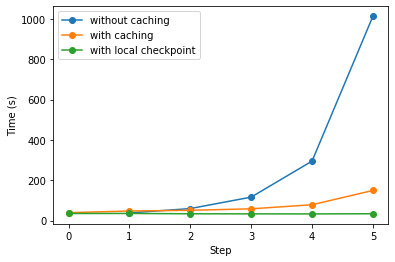

<matplotlib.legend.Legend at 0x7f5f70189390>

In [0]:
n_test_iter = 5
plt.plot(range(1,n_test_iter+1),without_caching_computation_times, 'o-', label="without caching") # /!\ No value for init
plt.plot(range(n_test_iter+1),with_caching_computation_times, 'o-', label="with caching")
plt.plot(range(n_test_iter+1),with_local_checkpoint, 'o-', label="with local checkpoint")
plt.xlabel("Step")
plt.ylabel("Time (s)")
plt.legend()

## Extensions

Extensions:
All _non optional_ extensions are rated over 15pts / 20. Select some _optional_ extensions as well to get extra points. Yes, maximal grade is 30/20, so you do not need to do all _optional_ extensions.

*Algorithm quality:* Make sure we are running things correctly
1. Compute the top movies per latent classes : the one having the highest p(s|z) for a given z.
2. Compute the log likelihood across iterations ? Try for several values of L. You can log these values to mlflow.
3. Split randomly your ratings in two folds, train (80%) and test (20%). Train the algorithm on the train ratings and look for the likelihood on the test ratings ? How does it compare to the likelihood on the train ratings?
4. If we suppose each movie can be represented by p(s|z) ∈ R^L, pick few movies and look at their nearest neighbors. (Optional + 2pts)
5. Can you exhibit common movie characteristics (year or genre) for the top movies of a latent class? (Optional + 2pts)

*Recommender System (Optional + 6pts)*
1. How could this algorithm be used as a recommender system ? Formulate the prediction task: what would be the new movies you would you recommend to a user in your database ?
2. Compute [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall) for both train and test ratings.
3. How could one use the vectorial representation of p(s|z) ∈ R^L to recommend movies to a user that has several movies s but was not in the training set (we thus do not know the value of p(z|u) )?


*LDA (Optional + 3pts)*

Compare PLSI with LDA (implemented in [spark mllib](https://spark.apache.org/docs/2.3.1/api/java/org/apache/spark/mllib/clustering/LDA.html)) in terms of performance, quality and recommender system.

# Algorithmic quality

###Top movies per latent class

In [0]:
nb_top_movies=5
ranking = ss.sparkContext.parallelize(np.arange(1,nb_top_movies+1).tolist()).map(lambda x: st.Row(Rank=x)).toDF()
for i in range(n_latent_classes):
  # rank the movies for the current z_class
  ranking_zi = p_s_knowing_z.select('movieId',sf.col("p(s|z)")[i]).orderBy(f"p(s|z)[{i}]",ascending=False).limit(5)
  # get the movie's names from their IDs and add an index for joining
  ranking_zi = ranking_zi.join(movies_df, on="movieId", how="left")
  ranking_zi = ranking_zi.select('title').withColumnRenamed("title",f"z={i}")   
  ranking_zi = ranking_zi.withColumn("Rank", sf.monotonically_increasing_id()+1)
  # add the ranking for the current z_class to the global ranking table
  ranking = ranking.join(ranking_zi, on="Rank", how="left")
  
ranking.show(truncate=False)

+----+--------------------------------+------------------------------------------------------------------------------+---------------------------------------------------------+
Rank|z=0 |z=1 |z=2 |
+----+--------------------------------+------------------------------------------------------------------------------+---------------------------------------------------------+
1 |Forrest Gump (1994) |Fargo (1996) |Matrix, The (1999) |
2 |Apollo 13 (1995) |Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)|Fight Club (1999) |
3 |Jurassic Park (1993) |Godfather, The (1972) |Lord of the Rings: The Fellowship of the Ring, The (2001)|
4 |Fugitive, The (1993) |Star Wars: Episode IV - A New Hope (1977) |Lord of the Rings: The Two Towers, The (2002) |
5 |Silence of the Lambs, The (1991)|Princess Bride, The (1987) |Lord of the Rings: The Return of the King, The (2003) |
+----+--------------------------------+------------------------------------------------------------------------------+---------------------------------------------------------+

### Influence of L

We compare the final log likelihood using a different number of latent classes L. This value correspond to the number of features used to describe the movies.  
Augmenting L makes the problem more complex and will increase computation time. It is important to choose a value of L that allow a suffisient representation of the data while staying not to great. We chose L=5

Out[56]:

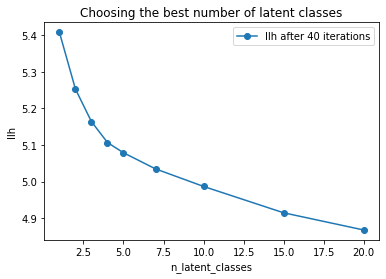

<matplotlib.legend.Legend at 0x7f5f70263690>

In [0]:
n_latent_classes_list = [1, 2, 3, 4, 5, 7, 10, 15, 20]
llh = [5.408, 5.253, 5.164, 5.107, 5.079, 5.035, 4.987, 4.915, 4.868]
plt.plot(n_latent_classes_list, llh, 'o-', label="llh after 40 iterations") 
plt.title("Choosing the best number of latent classes")
plt.xlabel("n_latent_classes")
plt.ylabel("llh")
plt.legend()

### Train_test_split

In [0]:
user_movies_interactions_train, user_movies_interactions_test = user_movies_interactions.randomSplit([0.8, 0.2], seed=42)
user_movies_interactions_train.localCheckpoint()
user_movies_interactions_test.localCheckpoint()

Out[64]: DataFrame[userId: string, movieId: string]

We slightly modified the functions for optimisation and to check the llh for training and testing

In [0]:
def log_likelihood2(observed_pairs, p_s_knowing_z, p_z_knowing_u, n_latent_classes):
  """
  We use directly p_s_knowing_z instead of count_ and count_z_s to avoid unnecessary redundant computation
  """
    T = observed_pairs.count()
    joined_data = observed_pairs.join(p_s_knowing_z, on='movieId').join(p_z_knowing_u, on='userId')
    product = joined_data.select("userId", "movieId", matrix_elementwise_product('p(s|z)', 'p(z|u)', n_latent_classes).alias("product"))
    p_s_knowing_u = product.select("userId", "movieId", matrix_sum_rows('product', n_latent_classes).alias("p(s|u)"))
    log_values = p_s_knowing_u.select("userId", "movieId", sf.log("p(s|u)").alias("log(p(s|u))"))
    sum_logs = log_values.select(sf.sum(sf.col('log(p(s|u))')).alias('sum_logs')).collect()[0][0]
    return -sum_logs/T

In [0]:
def run_plsi_with_valid(observed_pairs_train, observed_pairs_test, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    ss.sparkContext.setJobDescription("Initialization")

    p_z_knowing_u_and_s = initialize_statistics(observed_pairs_train, n_latent_classes).localCheckpoint()
    p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()
    count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()
    count_z = get_count_z(count_z_s, n_latent_classes).localCheckpoint()
    p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes).localCheckpoint()
    p_z_knowing_u_and_s.unpersist()
    llh_train = log_likelihood2(observed_pairs_train, p_s_knowing_z, p_z_knowing_u, n_latent_classes)
    llh_test = log_likelihood2(observed_pairs_test, p_s_knowing_z, p_z_knowing_u, n_latent_classes)
    mlflow.log_metric(key="llh_train", value=llh_train, step=0)
    mlflow.log_metric(key="llh_test", value=llh_test, step=0)
    print(f'LLH train: {llh_train:.10f}, LLH test: {llh_test:.10f}')
    
    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')
    
    iter_computation_times = [end_init_time - start_init_time]
    for i in range(n_iterations):
        start_e_step = time.time()
        ss.sparkContext.setJobDescription(f"Iteration {i+1}: E-step")
        # E step
        p_z_knowing_u_and_s = get_p_z_knowing_u_and_s(observed_pairs_train, count_z_s, count_z, p_z_knowing_u, n_latent_classes).localCheckpoint()
        p_s_knowing_z = get_p_s_knowing_z(count_z_s, count_z, n_latent_classes).localCheckpoint()
        p_z_knowing_u.unpersist()
        count_z_s.unpersist()
        count_z.unpersist()
        
        
        end_e_step = time.time()
#         print(f'Iteration {i+1}: E-step: {end_e_step - start_e_step:.1f}s')
        
        ss.sparkContext.setJobDescription(f"Iteration {i+1}: M-step")
        # M step
        p_z_knowing_u = get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()#.cache()
        count_z_s = get_count_z_s(p_z_knowing_u_and_s, n_latent_classes).localCheckpoint()#.cache()
        count_z = get_count_z(count_z_s, n_latent_classes).localCheckpoint()#.cache()
        p_z_knowing_u_and_s.unpersist()
        
        llh_train = log_likelihood(observed_pairs_train, p_s_knowing_z, p_z_knowing_u, n_latent_classes)
        llh_test = log_likelihood(observed_pairs_test, p_s_knowing_z, p_z_knowing_u, n_latent_classes)
        mlflow.log_metric(key="llh_train", value=llh_train, step=i+1)
        mlflow.log_metric(key="llh_test", value=llh_test, step=i+1)
        p_s_knowing_z.unpersist()
        
        end_m_step = time.time()
#         print(f'Iteration {i+1}: M-step: {end_m_step - end_e_step:.1f}s')
        print(f'LLH train: {llh_train:.10f}, LLH test: {llh_test:.10f}')
        
        step_time = end_m_step - start_e_step
        iter_computation_times.append(step_time)
        print(f'Iteration {i+1}: Total: {step_time:.1f}s')
            
    return get_p_s_knowing_z(count_z_s, count_z, n_latent_classes), iter_computation_times

In [0]:
n_iterations = 40
n_latent_classes = 5

with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    p_s_knowing_z, iter_computation_times = run_plsi_with_valid(user_movies_interactions_train, user_movies_interactions_test, n_iterations=n_iterations, n_latent_classes=n_latent_classes)

LLH train: 5.4069221625, LLH test: 5.4092290278
Initialization: 25.7s
LLH train: 5.4065545580, LLH test: 5.4090405089
Iteration 1: Total: 14.3s
LLH train: 5.4064108807, LLH test: 5.4090630608
Iteration 2: Total: 15.6s
LLH train: 5.4062143518, LLH test: 5.4090784452
Iteration 3: Total: 14.8s
LLH train: 5.4059197013, LLH test: 5.4090739118
Iteration 4: Total: 15.5s
LLH train: 5.4054504156, LLH test: 5.4090200434
Iteration 5: Total: 15.5s
LLH train: 5.4046703252, LLH test: 5.4088524148
Iteration 6: Total: 16.2s
LLH train: 5.4033317381, LLH test: 5.4084349347
Iteration 7: Total: 15.9s
LLH train: 5.4009827528, LLH test: 5.4074894220
Iteration 8: Total: 16.3s
LLH train: 5.3968136659, LLH test: 5.4054718070
Iteration 9: Total: 16.4s
LLH train: 5.3894500040, LLH test: 5.4013962347
Iteration 10: Total: 16.1s
LLH train: 5.3768350470, LLH test: 5.3937235572
Iteration 11: Total: 16.5s
LLH train: 5.3566585525, LLH test: 5.3807158596
Iteration 12: Total: 16.9s
LLH train: 5.3278842270, LLH test: 5.3617652331
Iteration 13: Total: 17.5s
LLH train: 5.2926276267, LLH test: 5.3389704747
Iteration 14: Total: 16.8s
LLH train: 5.2558458813, LLH test: 5.3165550117
Iteration 15: Total: 17.6s
LLH train: 5.2224275912, LLH test: 5.2980759738
Iteration 16: Total: 17.0s
LLH train: 5.1948725449, LLH test: 5.2846810757
Iteration 17: Total: 17.6s
LLH train: 5.1733036095, LLH test: 5.2755676804
Iteration 18: Total: 17.2s
LLH train: 5.1566582857, LLH test: 5.2693851119
Iteration 19: Total: 17.9s
LLH train: 5.1436583978, LLH test: 5.2650898814
Iteration 20: Total: 20.3s
LLH train: 5.1332696044, LLH test: 5.2620839355
Iteration 21: Total: 16.0s
LLH train: 5.1247671438, LLH test: 5.2600742478
Iteration 22: Total: 16.3s
LLH train: 5.1176942338, LLH test: 5.2589707119
Iteration 23: Total: 17.6s
LLH train: 5.1117823623, LLH test: 5.2586416777
Iteration 24: Total: 19.4s
LLH train: 5.1068229058, LLH test: 5.2588138197
Iteration 25: Total: 16.9s
LLH train: 5.1026013572, LLH test: 5.2592342990
Iteration 26: Total: 17.2s
LLH train: 5.0988684458, LLH test: 5.2597131201
Iteration 27: Total: 17.7s
LLH train: 5.0954555914, LLH test: 5.2601709182
Iteration 28: Total: 17.6s
LLH train: 5.0923960173, LLH test: 5.2605528041
Iteration 29: Total: 17.7s
LLH train: 5.0897641071, LLH test: 5.2609568909
Iteration 30: Total: 17.5s
LLH train: 5.0876247062, LLH test: 5.2615384672
Iteration 31: Total: 17.3s
LLH train: 5.0857745990, LLH test: 5.2622255182
Iteration 32: Total: 17.5s
LLH train: 5.0841157176, LLH test: 5.2631820850
Iteration 33: Total: 17.6s
LLH train: 5.0827083019, LLH test: 5.2644043921
Iteration 34: Total: 18.8s
LLH train: 5.0814885866, LLH test: 5.2657413732
Iteration 35: Total: 18.8s
LLH train: 5.0803421765, LLH test: 5.2671144283
Iteration 36: Total: 18.8s
LLH train: 5.0792659601, LLH test: 5.2686269920
Iteration 37: Total: 18.6s
LLH train: 5.0783290227, LLH test: 5.2702398902
Iteration 38: Total: 18.3s
LLH train: 5.0774824831, LLH test: 5.2717279777
Iteration 39: Total: 18.8s
LLH train: 5.0766879541, LLH test: 5.2729942769
Iteration 40: Total: 19.2s

We plot the llh for the train set and for the test set. We can see that the algorithm slightly overfits after 25 iterations.  
We can see that the execution time increase. This is surely due to splitting the dataset, making the parallelization less efficient. Moreover it shows that computing the log is the bottleneck (more complex mathematical operation).  
![my_test_image](files/plots/train_test_llh.png)

### Nearest neighbours

4. If we suppose each movie can be represented by p(s|z) ∈ R^L, pick few movies and look at their nearest neighbors. (Optional + 2pts)
5. Can you exhibit common movie characteristics (year or genre) for the top movies of a latent class? (Optional + 2pts)

First, we scatter the movies in a space with L=2 for visualization purposes. We can see that most movies are situated along the axis. We can assume that the movies in the upper left corner and in the lower right one are very different and might be liked by different types of user.

In [0]:
p_s_knowing_z_scatter = p_s_knowing_z.select(sf.col("p(s|z)")[0], sf.col("p(s|z)")[1])
display(p_s_knowing_z_scatter)

p(s|z)[0],p(s|z)[1]
0.0038819196946917496,2.927319546357705E-4
0.008703830312840537,0.020685336541623665
0.004017853146719009,5.610188088225811E-5
0.0067371492091023106,3.6421562686798914E-13
0.006668999805825621,0.003174484996620217
0.003580666449760061,3.5013335715698077E-6
0.004042289525555887,1.5758516143910014E-15
0.005426093513761746,5.955466615313704E-4
0.0032849265849778145,5.315698472426983E-4
0.003247215777622901,2.4089446281900959E-4


In [0]:
import numpy as np
movie_id = np.array(p_s_knowing_z.select('movieId').collect()).squeeze()
movie_features = np.array(p_s_knowing_z.select('p(s|z)').collect()).squeeze()

In [0]:
print(movie_id.shape)
print(movie_features.shape)

(247,)
(247, 5)

In [0]:
from sklearn.neighbors import NearestNeighbors
moviesNeighbors = NearestNeighbors(n_neighbors=3)
moviesNeighbors.fit(movie_features)

Out[98]: NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
 radius=1.0)

The closest neighbor of a movie is itself first like shown afterward

In [0]:
_, neigh_ind = moviesNeighbors.kneighbors(X=movie_features)
print(movie_id[:5])
print(neigh_ind[:5])

['296' '1090' '1394' '58559' '1265']
[[ 0 184 156]
 [ 1 2 87]
 [ 2 1 87]
 [ 3 94 98]
 [ 4 221 209]]

In [0]:
movies_df.where(movies_df.movieId == movie_id[0]).select('title').collect()[0]

Out[108]: Row(title='Pulp Fiction (1994)')

In [0]:
movies_df.where(movies_df.movieId == movie_id[184]).select('title').collect()[0]

Out[109]: Row(title='Shawshank Redemption, The (1994)')

In [0]:
movies_df.where(movies_df.movieId == movie_id[156]).select('title').collect()[0]

Out[110]: Row(title='Silence of the Lambs, The (1991)')

'Shawshank Redemption' and 'Silence of the Lambs' are neighbors of 'Pulp Fiction'

In [0]:
nb_top_movies=5
ranking = ss.sparkContext.parallelize(np.arange(1,nb_top_movies+1).tolist()).map(lambda x: st.Row(Rank=x)).toDF()
for i in range(n_latent_classes):
  # rank the movies for the current z_class
  ranking_zi = p_s_knowing_z.select('movieId',sf.col("p(s|z)")[i]).orderBy(f"p(s|z)[{i}]",ascending=False).limit(5)
  # get the movie's names from their IDs and add an index for joining
  ranking_zi = ranking_zi.join(movies_df, on="movieId", how="left")
  ranking_zi = ranking_zi.select('title').withColumnRenamed("title",f"z={i}")   
  ranking_zi = ranking_zi.withColumn("Rank", sf.monotonically_increasing_id()+1)
  # add the ranking for the current z_class to the global ranking table
  ranking = ranking.join(ranking_zi, on="Rank", how="left")
  
ranking.select('Rank','z=2').show(truncate=False)

+----+---------------------------------------------------------+
Rank|z=2 |
+----+---------------------------------------------------------+
1 |Lord of the Rings: The Fellowship of the Ring, The (2001)|
2 |Matrix, The (1999) |
3 |Fight Club (1999) |
4 |Lord of the Rings: The Two Towers, The (2002) |
5 |Lord of the Rings: The Return of the King, The (2003) |
+----+---------------------------------------------------------+

We can see that the top movies of a specific latent class often have a similar genre. This leads the movies of a latent class to often have the same year of production, corresponding to a trending genre.  
For instance we can see that the movies 'The lord of the Rings' are in the top of the same latent class along with other sci-fi movies that aired around the same time.

# Recommendation system

*Recommender System (Optional + 6pts)*
1. How could this algorithm be used as a recommender system ? Formulate the prediction task: what would be the new movies you would you recommend to a user in your database ?
2. Compute [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall) for both train and test ratings.
3. How could one use the vectorial representation of p(s|z) ∈ R^L to recommend movies to a user that has several movies s but was not in the training set (we thus do not know the value of p(z|u) )?

A simple way to use this algorithm as a recommendation system would be to recommend to the user the neighbour movies to the one the user liked.  
An other way would be to recommend the movies that are at the top of a latent class corresponding to the favorite movies of the user.  

If the user was not in the training set, we can use the movies he liked in the same way and recommend neighbor movies. Other method including graphs can also be useful in recommending movies from users with similar tastes.